## Timeseries demo
<br>
There are two ways to extract a time series: for a point or for a polygon. Below, we give you examples for both.<br>
If you prefer a GUI, then check out [viewer.terrascope.be](https://viewer.terrascope.be/), and go to <b>Area of Interest</b>. <br>
When you use this Notebook, you have access to more layers than in the GUI.


In [54]:
#import the necessary modules
import datetime
import requests
import matplotlib.pyplot as plt
import numpy as np
import sys
import seaborn as sns
import matplotlib.dates as mdates
from ipyleaflet import Map,DrawControl,GeoJSON, Polygon
from shapely.geometry import mapping, shape

In [ ]:
tsvBaseURL = 'https://services.terrascope.be/timeseries/v1.0/ts/'
response   = requests.get(tsvBaseURL) #this returns the layers that are available

In [5]:
if response.status_code == 200:
    layerlist = response.json()['layers']
else:
    raise IOError(response.text)

Let's investigate the layers that are offered. The list is not sorted, so let's sort it first.<br>
For brevity's sakeness, we only show the first 5 sorted products.

In [6]:
layersSorted = sorted(layerlist, key=lambda k: k['name'])
print(layersSorted[:5])

[{'name': 'BELGIAN_COSTAL_ZONE_S2_NS_2017_RGB', 'dates': [], 'bounds': {'xmin': 2.999712175851294, 'ymin': 50.45347391634443, 'xmax': 4.579549179235953, 'ymax': 51.45118220529982}}, {'name': 'BELGIAN_COSTAL_ZONE_S2_NS_2017_SPM', 'dates': [], 'bounds': {'xmin': 2.999712175851294, 'ymin': 50.45347391634443, 'xmax': 4.579549179235953, 'ymax': 51.45118220529982}}, {'name': 'BIOPAR_BA300_V1_GLOBAL', 'dates': [], 'bounds': {'xmin': -180.0044642857143, 'ymin': -59.995535714285715, 'xmax': 179.9955357142857, 'ymax': 80.00446428571428}}, {'name': 'BIOPAR_FAPAR300_V1_GLOBAL', 'dates': ['2013-10-16T00:00:00Z', '2013-10-22T00:00:00Z', '2013-11-02T00:00:00Z', '2013-11-12T00:00:00Z', '2013-11-22T00:00:00Z', '2013-12-02T00:00:00Z', '2013-12-12T00:00:00Z', '2013-12-22T00:00:00Z', '2014-01-02T00:00:00Z', '2014-01-12T00:00:00Z', '2014-01-22T00:00:00Z', '2014-02-02T00:00:00Z', '2014-02-12T00:00:00Z', '2014-02-22T00:00:00Z', '2014-03-04T00:00:00Z', '2014-03-14T00:00:00Z', '2014-03-24T00:00:00Z', '2014-04-

In [7]:
count = 0

dates     = ([l['dates'] for l in layersSorted])
len_dates = np.array([len(elem) for elem in dates])
empty     = np.size(np.where(len_dates == 0))
n_empty   = np.size(np.where(len_dates > 0))

print(">>>", n_empty, 'layers with data')
print('Layers with no dates')
print(">>>", empty, 'layers without data')

>>> 81 layers with data
Layers with no dates
>>> 28 layers without data


Let's first extract the timeseries of a point, for all layers that have 'TERRASCOPE' in their name

In [8]:
#let's use some list comprehension for compact coding
#the name for each item is added to the list TSLayers when attribute 'name' equals 'TERRASCOPE'
TSlayers = [item['name'] for item in layersSorted if 'TERRASCOPE' in item['name']]
TSlayers

['TERRASCOPE_S1_SLC_COHERENCE_V1_VH',
 'TERRASCOPE_S1_SLC_COHERENCE_V1_VV',
 'TERRASCOPE_S2_FAPAR_V2',
 'TERRASCOPE_S2_FCOVER_V2',
 'TERRASCOPE_S2_LAI_V2',
 'TERRASCOPE_S2_NDVI_V2']

In [9]:
def getTimeseriesForPoint(covId,tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                          start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                          lat=51.146,lon=3.682,printURL=False):

    tsURL   = tsvBaseURL + covId + '/point'
    payload = {
            'lon': str(lon),
            'lat': str(lat),
            'startDate': start.strftime('%Y-%m-%d'),
            'endDate': end.strftime('%Y-%m-%d')
    }
    if printURL:
        print(tsURL,payload)
    
    response=requests.get(tsURL,params=payload)
    
    if response.status_code == 200:
        timeseries = response.json()['results']
        return(timeseries)
    else:
        return([])
    
    

In [30]:
print('layer'.ljust(40), 'points')
print('---------------------------------------  ------')
for l in TSlayers:
    ts = getTimeseriesForPoint(covId=l,start=datetime.date(2020,1,1), end = datetime.date(2020,10,1), printURL=False)
    print(l.ljust(40),'{0:6d}'.format(len(ts)))


layer                                    points
---------------------------------------  ------
TERRASCOPE_S1_SLC_COHERENCE_V1_VH           174
TERRASCOPE_S1_SLC_COHERENCE_V1_VV           174
TERRASCOPE_S2_FAPAR_V2                      133
TERRASCOPE_S2_FCOVER_V2                     133
TERRASCOPE_S2_LAI_V2                        133
TERRASCOPE_S2_NDVI_V2                       133


So, there are more results for coherence. This is because both descending and ascending orbits are used.<br>
<br>
Let's have a look at the last time series that we have extracted, for NDVI.<br>
We'll only list the points that are valid (all others cannot be determined due to cloud cover.

In [31]:
print('date        average')
print('----------  -------')

ts_date  = []
ts_ndvi  = []

for d in ts:
    if d['result']['validCount'] > 0:
        print(d['date'], '  {0:.4f}'.format(d['result']['average']))
        
        #append to lists to plot the results later on
        ts_date.append(d['date'])
        ts_ndvi.append(np.round(d['result']['average'],3))

date        average
----------  -------
2020-01-01   0.2360
2020-01-04   0.3240
2020-01-06   0.3200
2020-01-19   0.3640
2020-01-26   0.3320
2020-02-13   0.4080
2020-03-19   0.4880
2020-03-21   0.5160
2020-03-24   0.5080
2020-03-26   0.5080
2020-03-31   0.5000
2020-04-05   0.5600
2020-04-08   0.6000
2020-04-10   0.5960
2020-04-13   0.7040
2020-04-20   0.7760
2020-04-23   0.7960
2020-04-25   0.7840
2020-05-05   0.8800
2020-05-15   0.8760
2020-05-18   0.8800
2020-05-20   0.8280
2020-05-23   0.8520
2020-05-25   0.8800
2020-05-28   0.9160
2020-05-30   0.8800
2020-06-07   0.8480
2020-06-22   0.6080
2020-06-24   0.8760
2020-07-02   0.8440
2020-07-07   0.5960
2020-07-12   0.7280
2020-08-01   0.4000
2020-08-08   0.3320
2020-08-13   0.3520
2020-08-18   0.3240
2020-08-21   0.3000
2020-09-02   0.4160
2020-09-05   0.2440
['2020-01-01', '2020-01-04', '2020-01-06', '2020-01-19', '2020-01-26', '2020-02-13', '2020-03-19', '2020-03-21', '2020-03-24', '2020-03-26', '2020-03-31', '2020-04-05', '2020-04-08

It's nice to have a table with dates and corresponding values, but a plot gives a better glance at the NDVI's evolution. We see the usual NDVI growing seasonal cycle.

(0, 1)

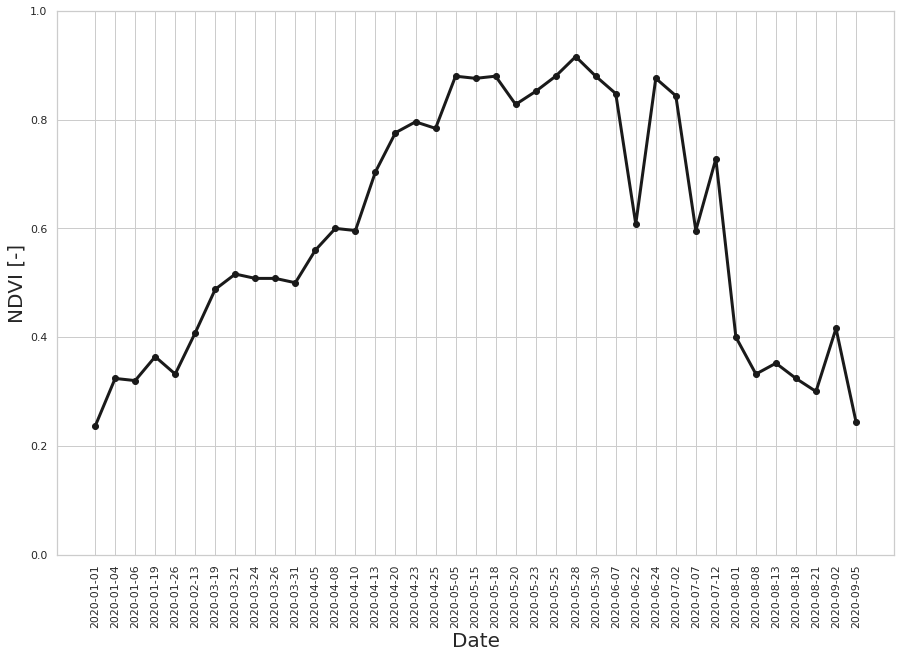

In [32]:
sns.set()
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
plt.plot(ts_date, ts_ndvi, 'k-o', lw=3)
plt.ylabel('NDVI [-]', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(rotation=90)
plt.ylim(0,1)

On to time series for a polygon then. <br>
This is done using a POST request, rather than a GET request for a point.

In [33]:
def getTimeseriesForPolygon(covId, polylist,
                            tsvBaseURL='https://services.terrascope.be/timeseries/v1.0/ts/',
                            start=datetime.date(2016,1,1),end=datetime.date(2030,12,31),
                            printURL=False):


    tsURL = tsvBaseURL + covId 
    tsURL = tsURL +'/geometry'

    payload = {
            "type": "Feature",
            "geometry": {
            "type": "Polygon",
            "coordinates": [
            
                polylist
            
            ]
            }
        }


    payload['endDate'] = end.strftime('%Y-%m-%d')
    
    if printURL:
        print(tsURL, payload)
    response = requests.post(url=tsURL,json=payload, params={'startDate':start.strftime('%Y-%m-%d'), 'endDate':end.strftime('%Y-%m-%d')})

    if response.status_code == 200:
        timeSeries = response.json()['results']   
        return(timeSeries)
    else:
        return([])

In [70]:
polygon = Polygon(
    locations=[(51.14, 3.65), (51.14, 3.66), (51.15, 3.66), (51.15, 3.65), (51.14, 3.65)],
    color="red",
    fill_color="green"
)

center_x = (np.nanmax(xs) + np.nanmin(xs)) / 2.
center_y = (np.nanmax(ys) + np.nanmin(ys)) / 2.
m  = Map(center=polygon.locations[2], zoom=11)
dc = DrawControl()

m.add_control(dc)
m.add_layer(polygon)

m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [72]:
PolyResults=[]
#redefine polygon to enable TS extraction
polygon=[]

point = [3.65, 51.14]
polygon.append(point)
point = [3.66, 51.14]
polygon.append(point)
point = [3.66, 51.15]
polygon.append(point)
point = [3.65, 51.15]
polygon.append(point)
point = [3.65, 51.14]
polygon.append(point)

for l in TSlayers:
    Tresult={}
    Tresult['name'] = l
    Tresult['series'] = getTimeseriesForPolygon(covId=l,polylist=polygon, start = datetime.date(2020,1,1), end = datetime.date(2020,10,1), printURL=False)
    PolyResults.append(Tresult)
    print(Tresult['name'], len(Tresult['series']))
    

[[3.65, 51.14], [3.66, 51.14], [3.66, 51.15], [3.65, 51.15], [3.65, 51.14]]
TERRASCOPE_S1_SLC_COHERENCE_V1_VH 174
TERRASCOPE_S1_SLC_COHERENCE_V1_VV 174
TERRASCOPE_S2_FAPAR_V2 133
TERRASCOPE_S2_FCOVER_V2 133
TERRASCOPE_S2_LAI_V2 133
TERRASCOPE_S2_NDVI_V2 133


Okay, let's print the time series.<Br>

In [77]:
ind = 3
ts_date = []
ts_ndvi = []

print(PolyResults[ind]['name'])
print('date'.ljust(11), 'total', ' valid', '  ratio','average')
print('---------- ------ ------  ------ -------')
cutoff = 0.9

selection = [r for r in PolyResults[ind]['series'] if r['result']['validCount'] / r['result']['totalCount'] > cutoff]

for r in selection:
    print(r['date'], '{0:6d}'.format(r['result']['totalCount']), '{0:6d}'.format(r['result']['validCount']), 
              ' {0:.4f}'.format(r['result']['validCount']/r['result']['totalCount']), ' {0:.4f}'.format(r['result']['average']))
    ts_date.append(r['date'])
    ts_ndvi.append(r['result']['average'])

TERRASCOPE_S2_FCOVER_V2
date        total  valid   ratio average
---------- ------ ------  ------ -------
2020-01-04  21576  21142  0.9799  0.2861
2020-01-06  21576  21098  0.9778  0.3124
2020-01-19  21576  21418  0.9927  0.3382
2020-01-26  21576  21458  0.9945  0.2457
2020-03-19  21576  21338  0.9890  0.3927
2020-03-21  21576  21368  0.9904  0.4822
2020-03-24  21576  21576  1.0000  0.4615
2020-03-26  21576  21576  1.0000  0.4331
2020-03-31  21576  21377  0.9908  0.4588
2020-04-05  21576  21576  1.0000  0.4650
2020-04-08  21576  21576  1.0000  0.4645
2020-04-10  21576  21576  1.0000  0.4592
2020-04-13  21576  20333  0.9424  0.4772
2020-04-20  21576  21576  1.0000  0.5071
2020-04-23  21576  21474  0.9953  0.5232
2020-04-25  21576  20585  0.9541  0.5155
2020-05-05  21576  21325  0.9884  0.5518
2020-05-15  21576  21576  1.0000  0.4276
2020-05-18  21576  21560  0.9993  0.4280
2020-05-28  21576  21576  1.0000  0.4714
2020-05-30  21576  21479  0.9955  0.4710
2020-06-07  21576  21320  0.9881 

This is okay: 
- the total number is the number of pixels in the polygon; it is constant, because the polygon doesn't change.
- the valid number is the number of pixels that are not covered by clouds. We are just printing the measures that have 90% cloud-free pixels
- the ratio is valid/total
- average is the value of the indicator at that date averaged over all valid pixels
<br>
Also for the polygon timeseries we show the NDVI results.

(0, 1)

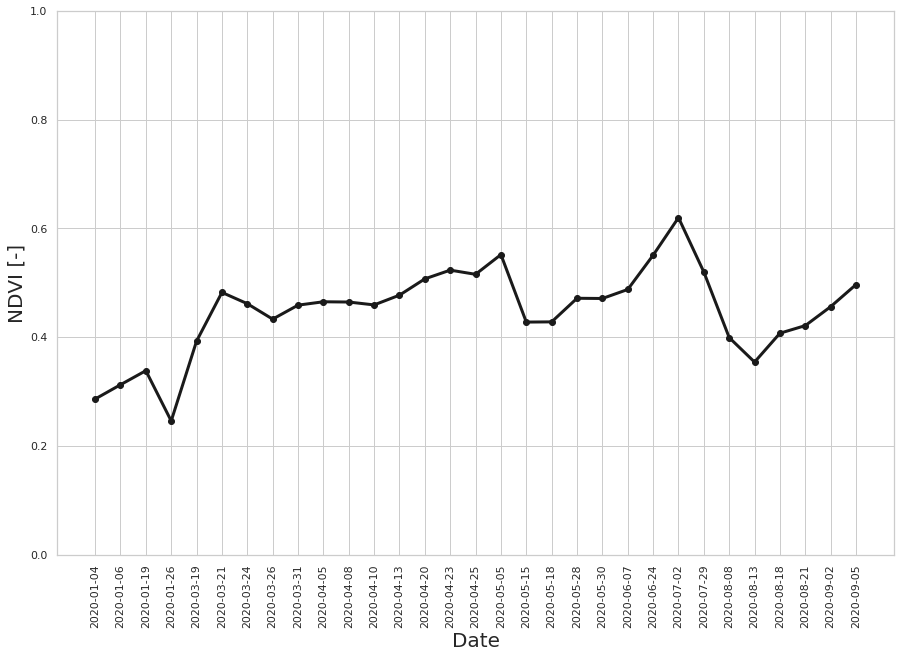

In [78]:
sns.set()
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
plt.plot(ts_date, ts_ndvi, 'k-o', lw=3)
plt.ylabel('NDVI [-]', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(rotation=90)
plt.ylim(0,1)

Now, we take a look at the Sentinel-1 Coherence timeseries. As for the NDVI, the timeseries is extracted, printed, and shown as a plot.

TERRASCOPE_S1_SLC_COHERENCE_V1_VV
date        total  valid   ratio average
---------- ------ ------  ------ -------
2020-01-03  21576  21576  1.0000  0.6427
2020-01-05  21576  20668  0.9579  0.5306
2020-01-09  21576  21576  1.0000  0.5806
2020-01-11  21576  21576  1.0000  0.6472
2020-01-15  21576  21576  1.0000  0.5739
2020-01-17  21576  19320  0.8954  0.6254
2020-01-18  21576  21576  1.0000  0.6755
2020-01-21  21576  21576  1.0000  0.4931
2020-01-23  21576  21576  1.0000  0.6512
2020-01-24  21576  21576  1.0000  0.5771
2020-01-27  21576  21576  1.0000  0.6815
2020-01-30  21576  21576  1.0000  0.5065
2020-02-02  21576  21576  1.0000  0.6408
2020-02-05  21576  21576  1.0000  0.4870
2020-02-08  21576  21576  1.0000  0.6229
2020-02-10  21576  20851  0.9664  0.5236
2020-02-11  21576  21576  1.0000  0.4499
2020-02-14  21576  21576  1.0000  0.5887
2020-02-16  21576  21463  0.9948  0.5098
2020-02-17  21576  21576  1.0000  0.3991
2020-02-20  21576  21576  1.0000  0.6385
2020-02-22  21576  2118

(0, 1)

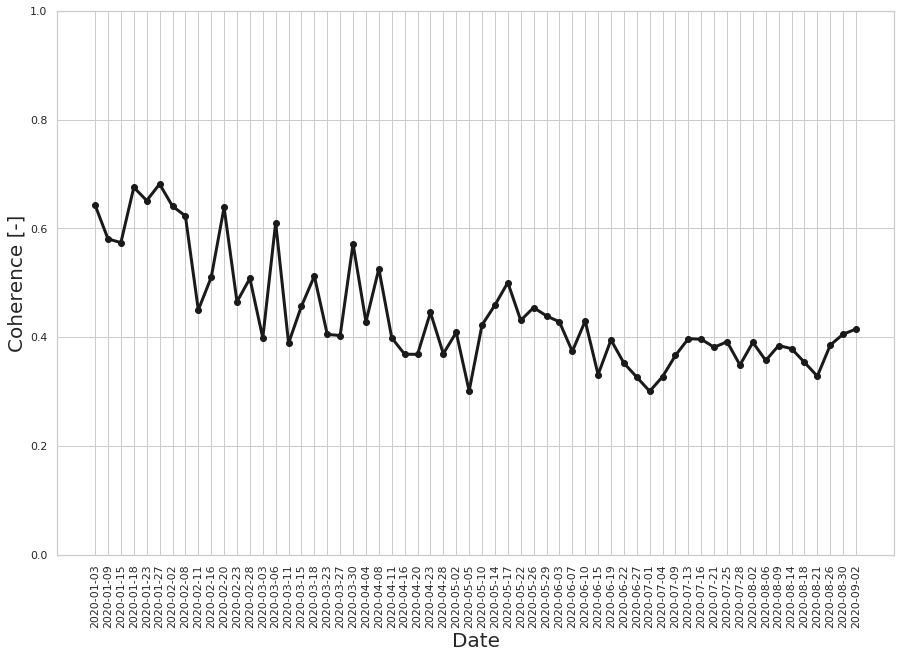

In [82]:
ind = 1

ts_date = []
ts_coh  = []

print(PolyResults[ind]['name'])
print('date'.ljust(11), 'total', ' valid', '  ratio','average')
print('---------- ------ ------  ------ -------')

cutoff = 0.0

selection = [r for r in PolyResults[ind]['series'] if r['result']['validCount'] / r['result']['totalCount'] > cutoff]

for r in selection:
    print(r['date'], '{0:6d}'.format(r['result']['totalCount']), '{0:6d}'.format(r['result']['validCount']), 
              ' {0:.4f}'.format(r['result']['validCount']/r['result']['totalCount']), ' {0:.4f}'.format(r['result']['average']))
    ts_date.append(r['date'])
    ts_coh.append(r['result']['average'])

#only plot every other value
sns.set()
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
plt.plot(ts_date[0:-1:2], ts_coh[0:-1:2], 'k-o', lw=3)
plt.ylabel('Coherence [-]', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.xticks(rotation=90)
plt.ylim(0,1)

This is a bit strange: 
- the valid number is <b>not</b> constant and equal to total. As RADAR is cloud penetrating, there's no reason for pixels to be invalid
